In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_probability as tfp
tfd = tfp.distributions

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models

### Data + EDA

In [3]:
# Get penguin data
penguins = pd.read_csv('./data/penguins_size.csv')

# Drop rows with NAs
penguins = penguins.dropna(axis=0)

In [4]:
penguins.shape

(334, 7)

### Multiple regression

In [10]:
# Get observations
adelie_mass_obs = penguins[penguins.species == 'Adelie']['body_mass_g'].values
adelie_sex_obs = penguins[penguins.species == 'Adelie']['sex'].replace({'MALE': 0, 'FEMALE': 1}).values
adelie_flipper_len_obs = penguins[penguins.species == 'Adelie']['flipper_length_mm'].values

In [6]:
adelie_flipper_len_obs.mean()

190.1027397260274

In [12]:
# Model
with pm.Model() as model_adelie_flipper_reg:
    
    adelie_flipper_len = pm.Data('adelie_flipper_len', adelie_flipper_len_obs)
    
    ### Prior params ###
    # SD
    sigma = pm.HalfStudentT('sigma', 100, 2000)
    
    # Linear coefs
    beta_0 = pm.Normal('beta_0', 0, 3000)
    beta_1 = pm.Normal('beta_1', 0, 3000)
    beta_2 = pm.Normal('beta_2', 0, 3000)
    
    # Mu
    mu = pm.Deterministic(
        'mu', 
        beta_0 + beta_1 * adelie_flipper_len + beta_2 * adelie_sex_obs)
    
    
    ### Likelihood X prior ###
    mass = pm.Normal(
        'mass', 
        mu=mu,
        sigma=sigma,
        observed=adelie_mass_obs)
    
    inference_data_adelie_flipper_reg = pm.sample(return_inferencedata=True, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_2, beta_1, beta_0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
# Summarize
az.summary(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1']).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-2339.3,982.8,-4239.1,-576.3,27.3,19.8,1294.0,1206.0,1.0
beta_1,31.8,5.2,22.3,41.5,0.1,0.1,1292.0,1219.0,1.0


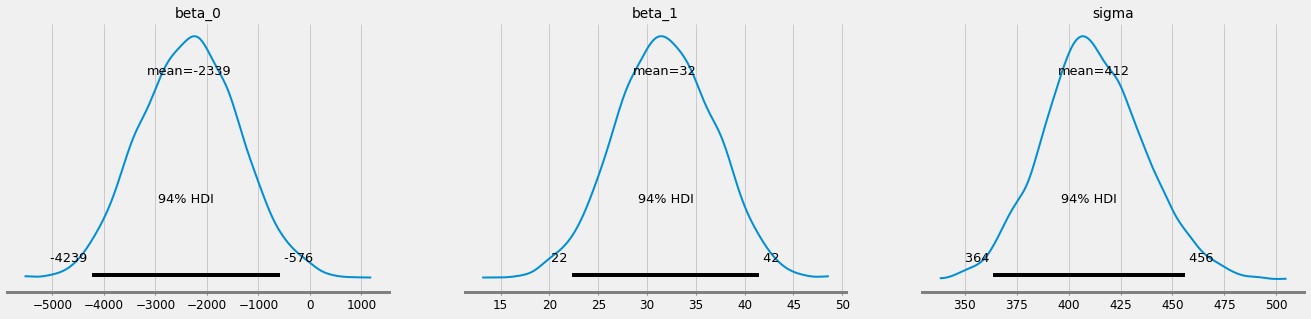

In [10]:
# Plot posterior
az.plot_posterior(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'sigma'],
    textsize=12, 
    lw=2
)
plt.show()

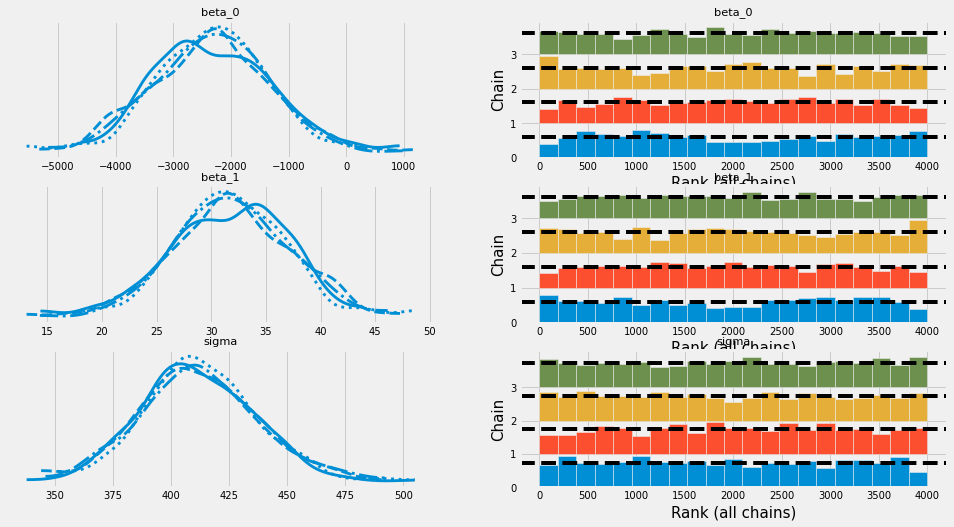

In [11]:
# Plot traces
az.plot_trace(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

Chains and ranks look decent, but not perfect.

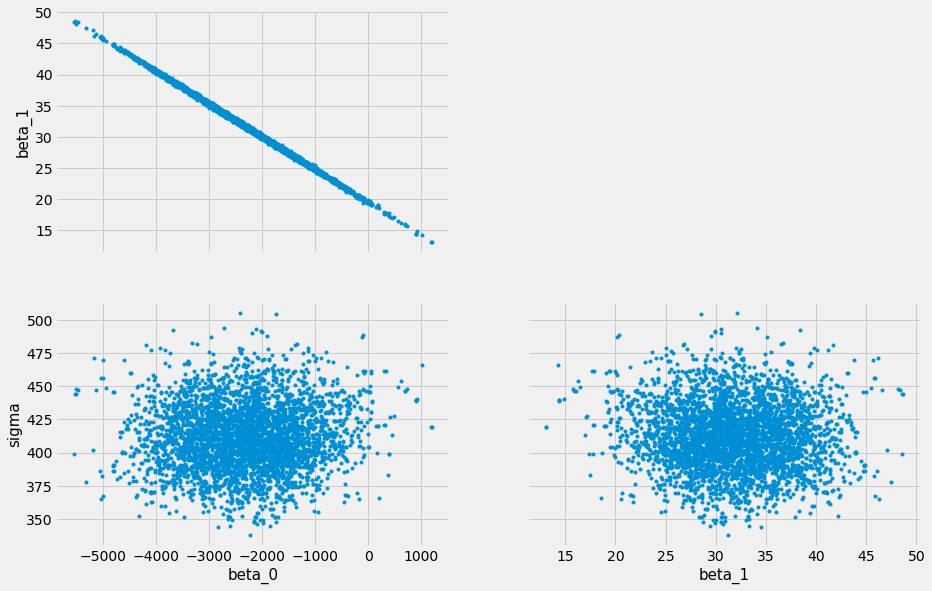

In [12]:
# Check divergences
az.plot_pair(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1', 'sigma'], divergences=True)
plt.show()

### Predictions - posterior

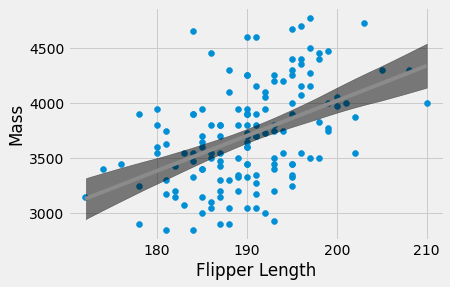

In [13]:
fig, ax = plt.subplots()
alpha_m = inference_data_adelie_flipper_reg.posterior.mean().to_dict()["data_vars"]["beta_0"]["data"]
beta_m = inference_data_adelie_flipper_reg.posterior.mean().to_dict()["data_vars"]["beta_1"]["data"]

flipper_len = np.linspace(adelie_flipper_len_obs.min(), adelie_flipper_len_obs.max(), 100)

flipper_len_mean = alpha_m + beta_m * flipper_len

ax.plot(flipper_len, flipper_len_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_len_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(
    adelie_flipper_len_obs, 
    inference_data_adelie_flipper_reg.posterior['mu'], 
    hdi_prob=0.94, 
    color='k', 
    ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass')
plt.show()

### Predictions - posterior predictive

In [14]:
with model_adelie_flipper_reg:
    
    # Set data to mean observed flipper len
    pm.set_data({
        'adelie_flipper_len': adelie_flipper_len_obs.mean().reshape(1)
    })
    
    # Get predictions
    posterior_preds = pm.sample_posterior_predictive(
        inference_data_adelie_flipper_reg.posterior,
        var_names=['mass', 'mu']
    )

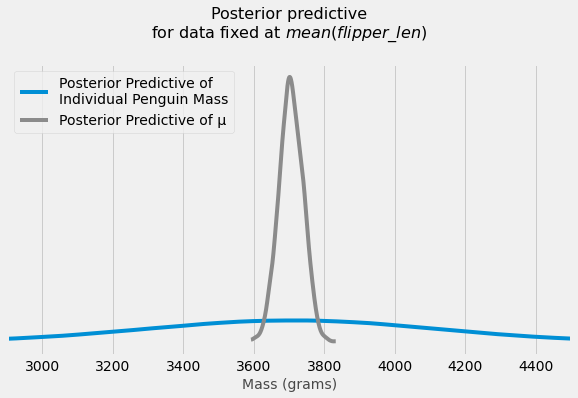

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))

az.plot_dist(
    posterior_preds['mass'], 
    label="Posterior Predictive of \nIndividual Penguin Mass", 
    ax=ax)

az.plot_dist(
    posterior_preds['mu'], 
    label="Posterior Predictive of μ", 
    color="C4", 
    ax=ax)

ax.set_xlim(2900, 4500)
ax.legend(loc=2)
ax.set_xlabel('Mass (grams)', fontsize=14, alpha=.7)
ax.set_yticks([])

plt.title('Posterior predictive\nfor data fixed at $mean(flipper\_len)$\n', fontsize=16)
plt.show()

### Centering 

To make the intercept ($\beta_0$) more interpretable, we can center our data.

We'll implement it using TFP.

In [16]:
# Center the variable
adelie_flipper_len_center = adelie_flipper_len_obs - adelie_flipper_len_obs.mean()

In [17]:
# Build the model
def gen_adelie_flipper_model(adelie_flipper_len):
    adelie_flipper_len = tf.constant(adelie_flipper_len, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        
        root = tfd.JointDistributionCoroutine.Root
        
        sigma = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        
        beta_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
        beta_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
        mu = beta_0[..., None] + beta_1[..., None] * adelie_flipper_len
        
        mass = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_adelie_flipper_regression

In [18]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True
)

# Use non-centered predictor, this gives the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_len_obs)

# Use centered predictor
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_len_center)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inference_data_adelie_flipper_length_center = az.from_dict(
    posterior={
        k: np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [14]:
# Plot 
# Plot traces
az.plot_trace(
    inference_data_adelie_flipper_length_center, 
    var_names=['beta_0', 'beta_1', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

NameError: name 'inference_data_adelie_flipper_length_center' is not defined